In [1]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool
from datashader.bokeh_ext import InteractiveImage
import datashader as ds
import numpy as np
import pandas as pd
import numexpr as ne
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, viridis, inferno, Set1, colormap_select as cm 
from datashader import reductions
from datashader.core import bypixel
from utils import toWebMercator, mega_color
from bokeh.models import HoverTool
from bokeh.tile_providers import WMTSTileSource
import requests
import shutil

/Users/lukestarnes/anaconda/envs/Py3.6Jupe/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# file = r'/users/lukestarnes/ADSB/h5/2016-12-07.h5'
file = r'/Users/lukestarnes/ADSB/h5/2016-10-01.h5'
day_file = r'/Users/lukestarnes/ADSB/h5/2016-10-01.h5'
mega_file = r'/Users/lukestarnes/ADSB/h5/mega5.h5'

store = pd.HDFStore(day_file)
points = store.select('data',columns=['Lat','Long','Cou','Mil','Man','Type','Op'],
                      where=['Lat>=-90','Lat<=90','Long>=-180','Long<=180']).dropna()
points = points.drop_duplicates()
points['x'],points['y'] = toWebMercator(points['Long'],points['Lat'])

points['Cou'] = points['Cou'].astype('category')
points['Cou'] = points['Cou'].replace([np.inf,-np.inf],np.nan).dropna()
points['Man'] = points['Man'].astype('category')
points['Man'] = points['Man'].replace([np.inf,-np.inf],np.nan).dropna()
points['Op'] = points['Op'].astype('category')
points['Op'] = points['Op'].replace([np.inf,-np.inf],np.nan).dropna()

store = pd.HDFStore(mega_file)
points_m = store.select('data')
points_m['x'],points_m['y'] = toWebMercator(points_m['Long'],points_m['Lat'])

def fx(t):
    try:
        return dt.datetime.fromtimestamp(t / 1000)
    except:
        return 0
points_m['RealTime'] = points_m['PosTime'].fillna(0).map(int).map(fx)

In [16]:
pp = points_m[points_m['Icao'] == 'E80445']
pp['PosTime'].sort_values().diff()

317287            NaN
321017        23747.0
324054        36955.0
197187    798472973.0
193529          539.0
192589          536.0
194571         2581.0
196379          975.0
195472            7.0
199454        56484.0
200418         2230.0
201443          820.0
202349           28.0
205257          165.0
203255          375.0
204072          415.0
206317        54952.0
212163         3632.0
207286          285.0
208320           54.0
210143          458.0
209235          462.0
210978         1469.0
213227        45421.0
217054         8757.0
214198         2692.0
215227           54.0
216141          982.0
219087           37.0
217906          713.0
             ...     
252084         1811.0
253031          874.0
254189          630.0
258294        36339.0
255266          468.0
256320        13983.0
257351         6520.0
259225         1045.0
260180           61.0
261326          911.0
265460        39201.0
262397        15358.0
263465         1937.0
264507          788.0
266393    

In [19]:
def split_flights(dataset):
    df = dataset.copy().reset_index(drop=True)
    df = df[np.logical_not(df['PosTime'].isnull())]
    empty=df[:1].copy()
    empty.loc[0, :] = (np.NaN,)*df.shape[1]
    
    paths = []
    for gid, group in df.groupby('Icao'):
        times = group['PosTime']
        group = group.sort_values('PosTime')
        for split_df in np.split(group.reset_index(drop=True), np.where(times.diff()>6000)[0]):
            if len(split_df) > 10:
                paths += [split_df, empty]
    if len(paths) > 0:
        split = pd.concat(paths,ignore_index=True)
        #  split['ascending'] = split.vertical_rate>0
    return split
flights = split_flights(points_m)

In order to quickly zoom on geographic areas, a reference file is downloaded and imported.

In [23]:
file_url = r'https://gist.githubusercontent.com/graydon/11198540/raw/7c1391f1677c2c1dafe114dc8010bd9b1218e3d0/country-bounding-boxes.py'
r = requests.get(file_url, stream=True)
if r.status_code == 200:
    with open('country_bboxes.py', 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)    
from country_bboxes import country_bounding_boxes as cbb

In [24]:
c_bboxes = pd.DataFrame([[k, cbb[k][0], *cbb[k][1]] for k in cbb.keys()], 
             columns=['Code', 'Country', 'Lat1', 'Long1', 'Lat2', 'Long2'])
c_bboxes['x1'], c_bboxes['y1'] = toWebMercator(c_bboxes['Lat1'], c_bboxes['Long1'])
c_bboxes['x2'], c_bboxes['y2'] = toWebMercator(c_bboxes['Lat2'], c_bboxes['Long2'])
c_bboxes.set_index('Code', inplace=True)

In [25]:
def country_to_tuple(cntry):
    # you can provide either the 2 digit code (e.g. US, CN, GB) or the full name (e.g. United States or China)
    s = None
    if cntry in c_bboxes.index: s = c_bboxes.ix[cntry]
    elif cntry in c_bboxes['Country'].values: s = c_bboxes[c_bboxes['Country'] == cntry].squeeze()
    if s is not None: return ((min(s.x1, s.x2), max(s.x1, s.x2)), (min(s.y1, s.y2), max(s.y1, s.y2)))        
    else: return

Here are a bunch of convenience variables for zooming the map to a specific area.  
The format is (X Range, Y Range) so if you do *var then you have the input for x_range and y_range

In [26]:
MaxBounds = ((-20048966.10, 20048966.10), (-20026376.39, 20026376.39))
TwoBounds = ((-20000000, 20000000), (-20000000, 20000000))
DataSetBounds = ((min(points.x),max(points.x)), (min(points.y),max(points.y)))
Top99Bounds = ((np.percentile(points.x,0.1), np.percentile(points.x,99.5)), 
               (np.percentile(points.y,0.1), np.percentile(points.y,99.5)))
USA_CONUS = ((-13884029, -7453304), (2698291, 6455972))
WesternEuro = ((-1181114, 4270391), (3000000, 8081620))
Germany = ((709336, 1600000), (6026907, 7270000))
Chicago = (( -9828281, -9717659), (5096658, 5161298))
Chinatown = (( -9759210, -9754583), (5137122, 5139825))
NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
LosAngeles = ((-13195052, -13114944), (3979242, 4023720))
Houston = ((-10692703, -10539441), (3432521, 3517616))
Austin = ((-10898752, -10855820), (3525750, 3550837))
NewOrleans = ((-10059963, -10006348), (3480787, 3510555))
Atlanta = ((-9507853,-9274873), (3927030, 4069506))
USA = country_to_tuple('US')
China = country_to_tuple('China')
Russia = country_to_tuple('Russia')
China = country_to_tuple('China')
India = country_to_tuple('India')
Japan = country_to_tuple('Japan')
SKorea = country_to_tuple('S. Korea')
xrange, yrange = USA

## Datashader

The below functions takes a datashader image and puts it on a black background.

In [27]:
def bg(img): return tf.set_background(img,"black")

For datashader, you define your image size and then the points and it computes the pixel value based on the mapping of data to pixels.

Below is the initial setup. Note that Top99Bounds centers the plot on the top 99% of the data (IOW, tosses outliers). 

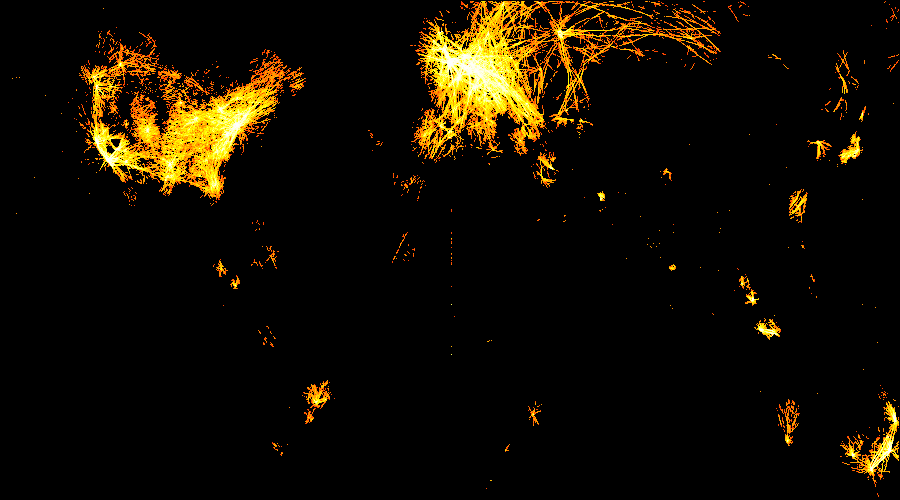

In [28]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *Top99Bounds)
agg = bypixel(points_m, canvas, glyph, ds.count())
canvas.points(points_m, 'x', 'y', agg=reductions.count())
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

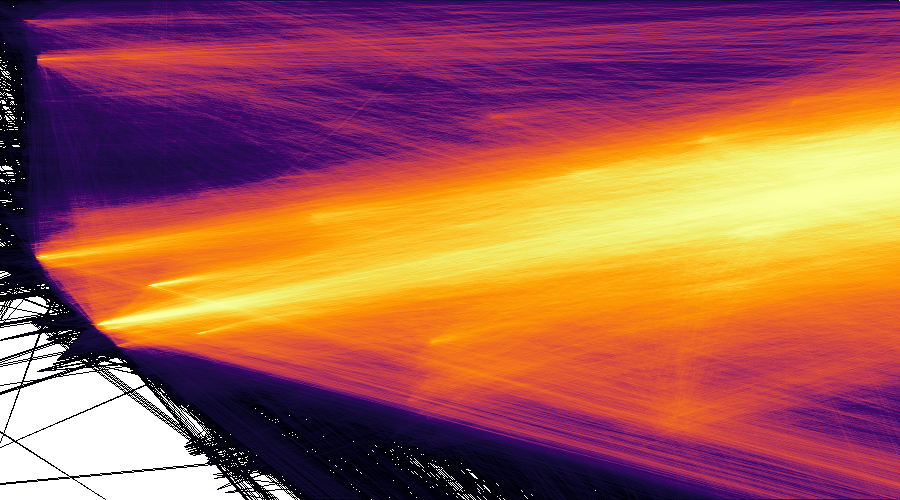

In [31]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *USA_CONUS)
# agg = bypixel(points_m, canvas, glyph, reductions.count())
agg = canvas.line(points_m, 'x', 'y', ds.count())
# canvas.points(points_m, 'x', 'y', agg=reductions.count())
tf.shade(agg, cmap = inferno)

Below is data for the world.

And here is the data for the US.

In [400]:
points_m.columns

Index(['Icao', 'Lat', 'Long', 'PosTime', 'Man', 'Type', 'x', 'y', 'RealTime'], dtype='object')

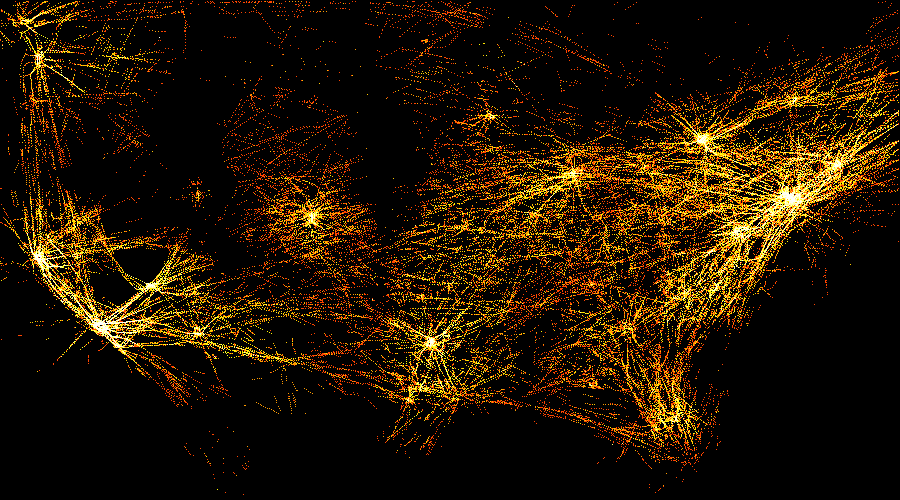

In [395]:
canvas = ds.Canvas(plot_width, plot_height,*USA_CONUS)
glyph = ds.glyphs.Point('x', 'y')
agg = bypixel(points_m, canvas, glyph, ds.count())
canvas.points(points_m, 'x', 'y', agg=ds.count())
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

You can also select the data based on an attribute. Here is the data where the aircraft is registered (the Cou field) to the US.

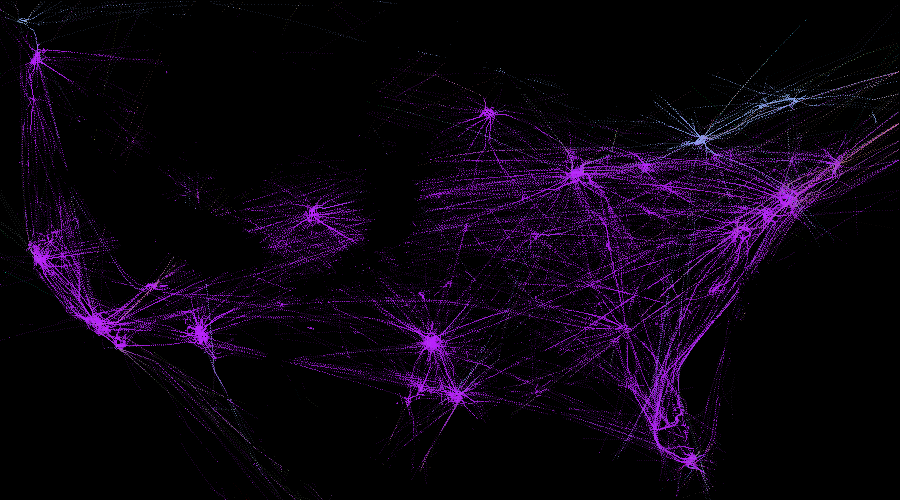

In [392]:
np.seterr(divide='ignore', invalid='ignore')
def create_image(x_range, y_range, w, h, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points, 'x', 'y', ds.count_cat('Cou'))
    img = tf.shade(pts, color_key=mega_color)
    return bg(img)
create_image(*USA_CONUS,plot_width, plot_height)

In [284]:
mask = np.where(points['Op'] == 'DELTA AIR LINES INC     - ATLANTA, GA')
points.iloc[list(mask), points.columns.get_loc("Op")] = 'Delta Air Lines'

In [374]:
points_m['Type'] = points_m['Type'].astype('category')
top_airlines_series = points_m['Type'].value_counts()[:10]
top_airlines = sorted(list(points_m['Type'].value_counts()[:10].keys()))
points_airlines = points_m.copy()
points_airlines['Type'] = points_airlines['Type'].cat.set_categories(top_airlines)
points_airlines['Type'].dropna(inplace=True)

In [376]:
c_brewer = ['#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', 
            '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', 
            '#ffff99']
c_brewer_nominal_names = ['red', 'light orange', 'orange', 'light purple', 
                          'purple', 'light blue', 'blue', 'light green', 
                          'green', 'light red', 'yellow']
top_airlines_df = pd.DataFrame(top_airlines_series)
top_airlines_df['Color'] = pd.Series(dict(zip(top_airlines,c_brewer_nominal_names)))
top_airlines_df.sort_values('Type', ascending=False)

Type         Color
B738  134488          blue
A320   98443  light orange
A321   51892        orange
A319   37695           red
B737   22614    light blue
B773   17648         green
E170   16977     light red
B739   15376   light green
A332   14048  light purple
A333   13205        purple

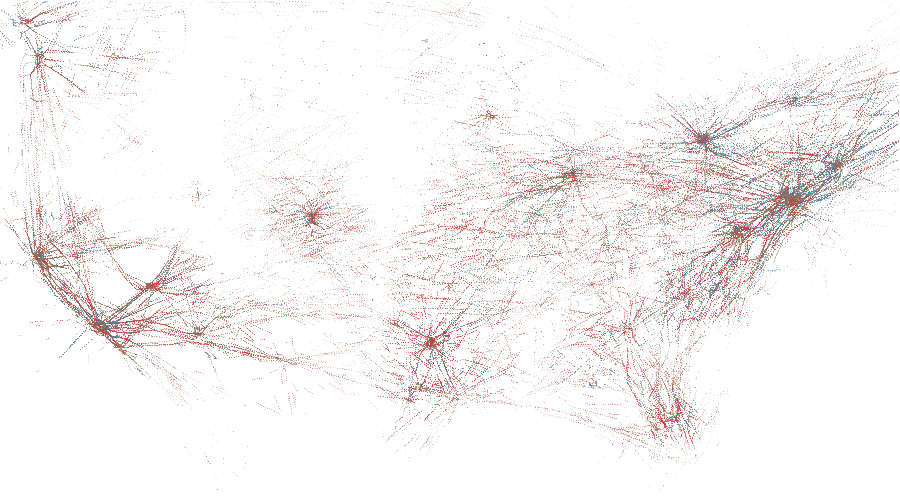

In [381]:
# np.seterr(divide='ignore', invalid='ignore')
# canvas = ds.Canvas(plot_width, plot_height, *USA_CONUS)
# agg = canvas.points(points_airlines, 'x', 'y', ds.count_cat('Op'))
# bg(tf.shade(agg, color_key=dict(zip(top_airlines, c_brewer)), how='eq_hist'))
Greys9_r = list(reversed(Greys9))[:-2]

np.seterr(divide='ignore', invalid='ignore')
def create_image(x_range, y_range, w, h, spread=False):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points_airlines, 'x', 'y', ds.count_cat('Type'))
    img = tf.shade(pts, cmap=inferno)
    if spread: img = tf.spread(img,px=spread)
    return tf.dynspread(img, threshold=0.3, max_px=3)
create_image(*USA_CONUS,plot_width, plot_height)


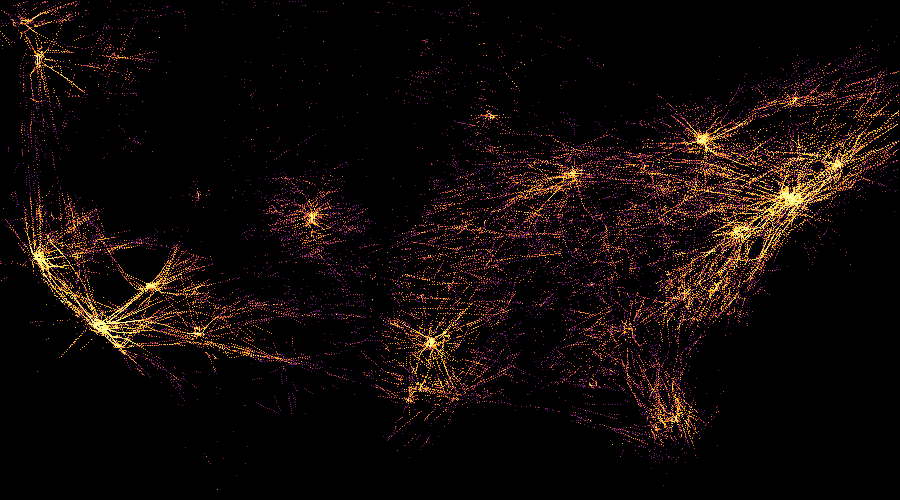

In [318]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *USA_CONUS)
agg = bypixel(points_m, canvas, glyph, reductions.count())
canvas.points(points_m, 'x', 'y', agg=reductions.count())
bg(tf.shade(agg, cmap = inferno))

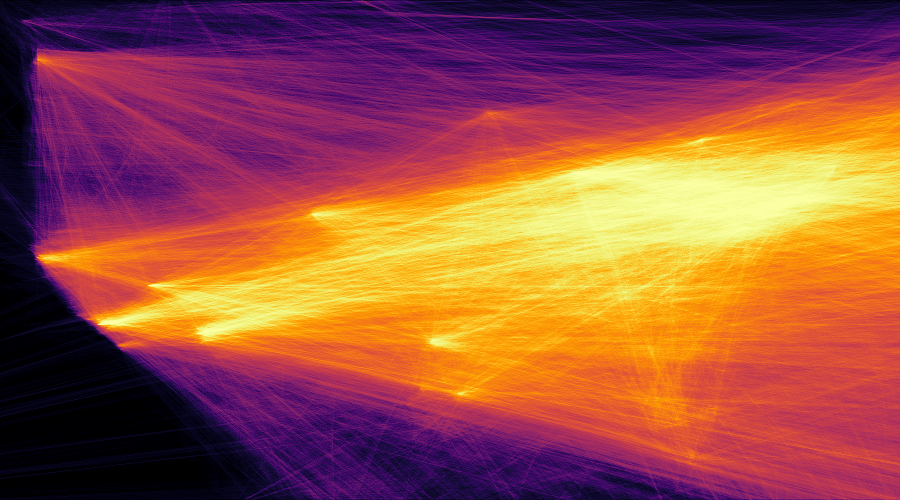

In [333]:
np.seterr(divide='ignore', invalid='ignore')
def create_image(x_range, y_range, w, h, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
#     pts = cvs.points(points_m, 'x', 'y')
    agg = cvs.line(points, 'x', 'y',  ds.count())
    img = tf.shade(agg, cmap=inferno)
#     if spread: img = tf.spread(img,px=spread)
    return bg(img)
create_image(*USA_CONUS,plot_width, plot_height)

# Datashader with Bokeh

In [14]:
output_notebook()

Loading BokehJS ...

Below is a Datashader image being shown within Bokeh. This relies on the InteractiveImage function to tie the two together. You can also see the nice map tile (map tiles are one of the nice things Bokeh brings to the table).

In [64]:
def base_plot(tools='pan,wheel_zoom,box_zoom,reset',webgl=False,
              xrange=xrange,yrange=yrange,plot_width=int(900),plot_height=int(500),
             bok_cir = True):
    p = bp.figure(tools=tools,
                  plot_width=plot_width, plot_height=plot_height,
                  x_range=xrange, y_range=yrange, outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0, webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    if bok_cir:
        p.circle(x=points.x,y=points.y,color='red', size=2, alpha=0.4) 
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    return p

In [386]:
xr, yr = USA_CONUS
p = base_plot(xrange=xr,yrange=yr,bok_cir=False) 
def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points_m, 'x', 'y')
    img = tf.shade(pts, cmap=Hot)
    return img
 
InteractiveImage(p, image_callback)